In [21]:
import os
import sys
sys.path.insert(0, "../models/multimodal")

In [22]:
import torch
from pathlib import Path
from recommender import ImageRecommender
bin_root = Path("../models/multimodal/bin")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
recommender = ImageRecommender(bin_root/"model_22.pth", bin_root/"embedding.pkl")
recommender.to(device)

In [29]:
import pandas as pd

root = Path("../data")
df = pd.read_csv(root / "flickr8k/captions_test.txt").reset_index(drop=True)
df.head()

,image,caption
0,229951087_4c20600c32.jpg,An older man rows a boat .
1,3535056297_e16f014cb7.jpg,A group of people are looking into the distance .
2,3248220732_0f173fc197.jpg,The skier is leaning forward in the snow .
3,3430100177_5864bf1e73.jpg,Many people are standing outside on a street f...
4,2189995738_352607a63b.jpg,Children are playing and swimming in a boy of ...


In [30]:
images= df["image"]
images.head()

0     229951087_4c20600c32.jpg
1    3535056297_e16f014cb7.jpg
2    3248220732_0f173fc197.jpg
3    3430100177_5864bf1e73.jpg
4    2189995738_352607a63b.jpg
Name: image, dtype: object

In [31]:
captions = df["caption"]
captions.head()

0                           An older man rows a boat .
1    A group of people are looking into the distance .
2           The skier is leaning forward in the snow .
3    Many people are standing outside on a street f...
4    Children are playing and swimming in a boy of ...
Name: caption, dtype: object

In [32]:
import numpy as np
from tqdm import tqdm

cap_vecs = np.zeros((len(captions), 1024))
for i, caption in enumerate(tqdm(captions)):
    embd_cap = recommender.vectorizer(caption).unsqueeze(1).to(device)
    cap_vec = recommender.model.forward_cap(embd_cap).to("cpu").detach().numpy()
    cap_vecs[i] = cap_vec

100%|██████████| 1651/1651 [00:01<00:00, 1025.26it/s]


In [33]:
from PIL import Image
import torchvision.transforms as transforms
image_path = Path(root / "flickr8k/images")
transform = transforms.Compose([
    transforms.Resize((224,244)),
    transforms.ToTensor()])

img_vecs = np.zeros((len(images), 1024))

images = df["image"].unique()
for i, image in enumerate(tqdm(images)):
    embd_img = transform(Image.open(image_path / image).convert("RGB")).to(device)
    img_vec = recommender.model.forward_cnn(embd_img.unsqueeze(0)).squeeze(0)
    img_vecs[i] = img_vec.to("cpu").detach().numpy()

100%|██████████| 1511/1511 [00:22<00:00, 67.63it/s]


In [82]:
from sklearn.decomposition import PCA, TruncatedSVD

cap_pca = PCA(n_components=2)
cap_pca.fit(cap_vecs)

cap_svd = TruncatedSVD(n_components=2, algorithm="arpack")
cap_svd.fit(cap_vecs)

img_pca = PCA(n_components=2)
img_pca.fit(img_vecs)

cap_data = cap_svd.transform(cap_vecs)
img_data = img_pca.transform(img_vecs)

In [83]:
X1 = cap_data[:,0]
print(X1.shape)
X2 = cap_data[:,1]
X2.shape

(1651,)


(1651,)

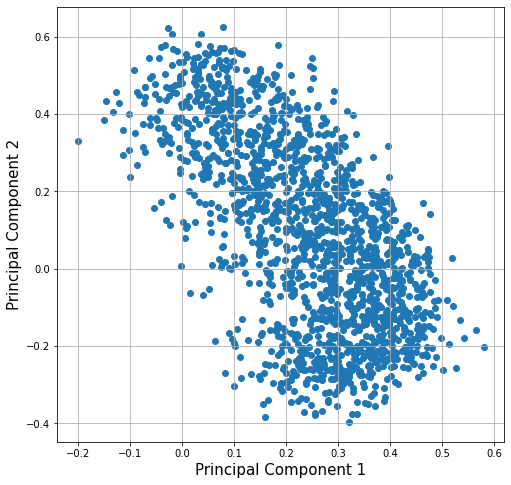

In [84]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.scatter(X1,X2)
ax.grid()

In [67]:
from sklearn.cluster import DBSCAN, OPTICS, KMeans
from sklearn.cluster import AgglomerativeClustering
clustering = DBSCAN(eps=0.1, min_samples=32).fit(cap_data)

#clustering = AgglomerativeClustering().fit(data)
#clustering = OPTICS(min_samples=16).fit(cap_data)
#clustering = KMeans(n_clusters=8).fit(data)
l = clustering.labels_

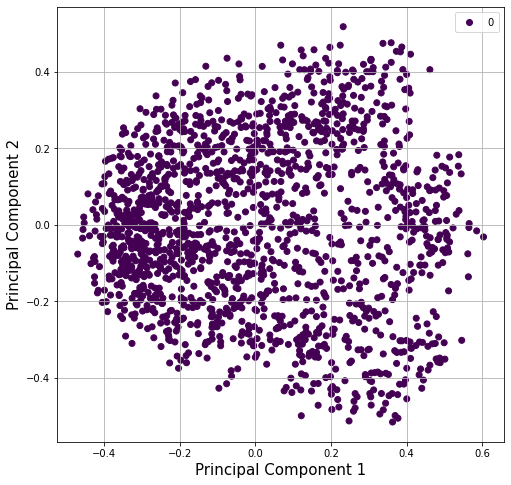

In [68]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
p = (l!=-1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
scatter = ax.scatter(X1[p],X2[p],c = l[p])
legend1 = ax.legend(*scatter.legend_elements())
ax.grid()

In [65]:
np.unique(l)

array([-1,  0,  1,  2,  3])

In [66]:
import spacy
spacy = spacy.load("en")
for k in np.unique(l)[1:]:
    freq_dict = dict()
    for caption in captions[l == k]:
        tokens = [tok.text for tok in spacy.tokenizer(caption.lower())]
        for token in tokens:
            if token in freq_dict:
                freq_dict[token] += 1
            else:
                freq_dict[token] = 1
    items = sorted(freq_dict.items(), key=lambda item: item[1], reverse=True)[:10]
    items = list(map(lambda x: x[0], items))
    print(k, items)

0 ['a', '.', 'in', 'the', 'and', 'on', 'with', 'man', 'is', 'of']
1 ['a', '.', 'in', 'the', 'with', 'on', 'is', 'and', 'boy', 'of']
2 ['a', '.', 'in', 'the', 'is', 'girl', 'boy', 'and', 'on', 'young']
3 ['a', '.', 'the', 'on', 'in', 'man', 'is', 'and', 'blue', 'riding']


In [16]:
captions[l == 0].reset_index(drop=True)

0      White tents lined up with red Chinese lanterns...
1       A man stands atop a rocky cliff over the water .
2                   Man and boy are swimming in a pool .
3      A group of people mill around while a man in a...
4      A little boy is playing with a toy guitar and ...
                             ...                        
669    A young black child is wrapped in a white robe...
670        A man plays an instrument next to a drummer .
671    A helmeted boy flies through the air on a snow...
672    Four young children playing on a stone bear wi...
673                               A young girl dancing .
Name: caption, Length: 674, dtype: object

In [69]:
X1 = img_data[:,0]
print(X1.shape)
X2 = img_data[:,1]
X2.shape

(1651,)


(1651,)

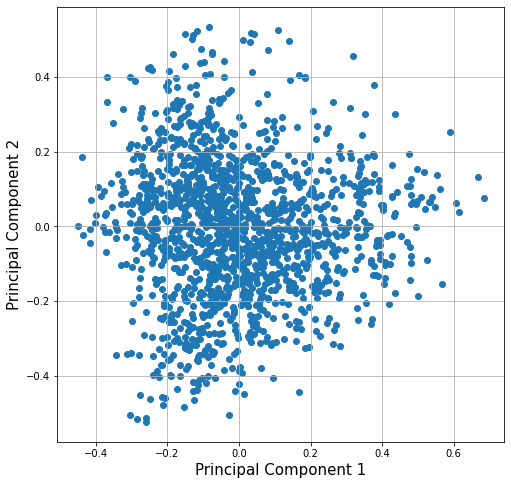

In [70]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.scatter(X1,X2)
ax.grid()

In [77]:
from sklearn.cluster import DBSCAN, OPTICS, KMeans
from sklearn.cluster import AgglomerativeClustering
clustering = DBSCAN(eps=0.03, min_samples=8).fit(img_data)

#clustering = AgglomerativeClustering().fit(data)
#clustering = OPTICS(min_samples=8).fit(vecs)
#clustering = KMeans(n_clusters=8).fit(data)
l = clustering.labels_

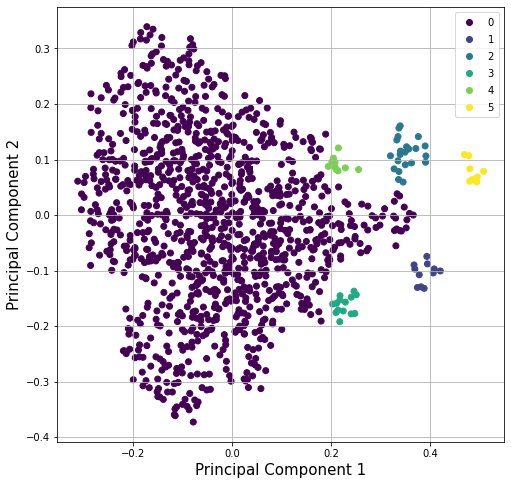

In [78]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
p = (l!=-1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
scatter = ax.scatter(X1[p],X2[p],c = l[p])
legend1 = ax.legend(*scatter.legend_elements())
ax.grid()